In [1]:
### Fire Model 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sigkernel
import torch

In [3]:
def vegrowth(array,a,b,c,d,s,t):
    return (np.clip(array + a*(1-array)*t + np.random.normal(0,s,(size,size)),0,1))
def averageheat(array):
    north = np.roll(array, 1, axis=0)
    south = np.roll(array, -1, axis=0)
    east = np.roll(array, 1, axis=1)
    west = np.roll(array, -1, axis=1)

    # Diagonal neighbors (weight = 1/sqrt(2))
    northeast = np.roll(north, 1, axis=1) * (1 / np.sqrt(2))
    northwest = np.roll(north, -1, axis=1) * (1 / np.sqrt(2))
    southeast = np.roll(south, 1, axis=1) * (1 / np.sqrt(2))
    southwest = np.roll(south, -1, axis=1) * (1 / np.sqrt(2))

    # Combine contributions and normalize
    adjacent = north + south + east + west
    diagonal = northeast + northwest + southeast + southwest
    weights = 4 + 4 * (1 / np.sqrt(2))  # ~6.828

    neighborheat = (adjacent + diagonal) / weights
    #print(neighborheat)
    return neighborheat
def firespread(array,vegarray,a,b,c,d,s,t):
    return (np.clip(array + b*(averageheat(array)*vegarray)*t -d*array*t+ np.random.normal(0,s,(size,size)),0,1))
def fireconsume(array,heatarray,a,b,c,d,s,t):
    return (np.clip(array - c*heatarray*t,0,1))

In [4]:
def predictout(VegBase,HeatBase,size,predl,a,b,c,d,s,t):
    Vpred = np.zeros((size,size,predl))
    Hpred = np.zeros((size,size,predl))

    V = vegrowth(VegBase,a,b,c,d,s,t)
    H = firespread(HeatBase, V,a,b,c,d,s,t)
    V = fireconsume(V,H,a,b,c,d,s,t)
    Vpred[:,:,0] = V
    Hpred[:,:,0] = H

    for i in range(predl-1):
        V = vegrowth(V,a,b,c,d,s,t)
        H = firespread(H, V,a,b,c,d,s,t)
        V = fireconsume(V,H,a,b,c,d,s,t)
        Vpred[:,:,i+1] = V
        Hpred[:,:,i+1] = H
    
    return Vpred,Hpred

def interveave(Veg,Heat,size,predl):
    Veg = Veg.reshape(size*size,predl).T
    Heat = Heat.reshape(size*size,predl).T
    combined = np.empty((predl, 2*size*size))
    combined[:,0::2] = Veg
    combined[:,1::2] = Heat
    return(combined)

def stackblock(Veg,Heat,size,predl):
    Veg = Veg.reshape(size*size,predl).T
    Heat = Heat.reshape(size*size,predl).T
    combined = np.empty((predl, 2*size*size))
    combined[:,0:(size*size)] = Veg
    combined[:,(size*size):] = Heat
    return(combined)

def plotsequence(Veg,Heat,predl):

    fig, axs = plt.subplots(int(predl/10), 10, figsize=(10, 2))  # Explicit axes objects

    for i in range(predl):
        row = i // 10
        col = i % 10
        ax = axs[row, col]

        ax.imshow(Veg[:,:,i], cmap="Greens", vmin=0, vmax=1)

        ax.imshow(Heat[:,:,i], cmap="Reds", alpha=0.8*(Heat[:,:,i] > 0.2), vmin=0, vmax=1)
        
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
def energy_score(forecasts, observations):
    """
    Compute the Energy Score (ES) for probabilistic forecasts.
    
    Args:
        forecasts: np.array of shape (M, T, D) -> M ensemble members, T time steps, D dimensions
        observations: np.array of shape (N, T, D) -> N true observation paths
    
    Returns:
        Expected Energy Score (scalar)
    """
    M, T, D = forecasts.shape  # Ensemble size, time steps, dimensions
    N, _, _ = observations.shape  # Number of observation paths

    # Compute pairwise distance between forecast samples
    diff_forecast = forecasts[:, None, :, :] - forecasts[None, :, :, :]  # Shape (M, M, T, D)
    term1 = np.mean(np.linalg.norm(diff_forecast, axis=-1))  # Expectation over X, X'

    # Compute pairwise distance between forecasts and observations
    diff_obs = forecasts[:, None, :, :] - observations[None, :, :, :]  # Shape (M, N, T, D)
    term2 = np.mean(np.linalg.norm(diff_obs, axis=-1))  # Expectation over X, y

    # Energy Score
    es = term2 -(1/2)*term1 ##- 2 * term2
    return es

def MSE(forecasts, observations):
    """
    Compute Mean Squared Error (MSE) between probabilistic forecasts and true observations.

    Args:
        forecasts: np.array of shape (M, T, D) -> M ensemble members, T time steps, D dimensions
        observations: np.array of shape (N, T, D) -> N true observation paths

    Returns:
        Expected MSE (scalar)
    """
    # Compute pairwise squared differences
    squared_diff = (forecasts[:, None, :, :] - observations[None, :, :, :]) ** 2  # Shape (M, N, T, D)
    
    # Average over all ensemble members, observation paths, time steps, and dimensions
    mse = np.mean(squared_diff)
    return mse


def variogram_score(forecasts, observations, gamma=1):
    """
    Compute the Variogram Score (VS) for probabilistic forecasts.
    
    Args:
        forecasts: np.array of shape (M, T, D) -> M ensemble members, T time steps, D dimensions
        observations: np.array of shape (N, T, D) -> N true observation paths
        gamma: float, exponent (default is 1)
    
    Returns:
        Expected Variogram Score (scalar)
    """
    M, T, D = forecasts.shape  # Forecast ensemble
    N, _, _ = observations.shape  # True observations

    # Compute pairwise absolute differences in forecasts
    diff_forecast = np.abs(forecasts[:, :, None, :] - forecasts[:, None, :, :]) ** gamma  # (M, T, D, D)

    # Compute pairwise absolute differences in observations
    diff_obs = np.abs(observations[:, :, None, :] - observations[:, None, :, :]) ** gamma  # (N, T, D, D)

    # Compute squared differences between forecast and observation variograms
    vs_term = (diff_forecast[:, None, :, :, :] - diff_obs[None, :, :, :, :]) ** 2  # (M, N, T, D, D)

    # Take the mean over all ensemble members, observation paths, time steps, and dimensions
    vs = np.mean(vs_term)
    return vs


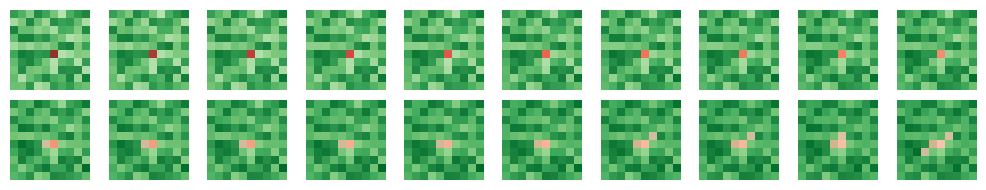

In [6]:
size = 10
a = 0.1 #Vegetation growth
b = 1.2 #Fire start senseitivity
c = 0.3 #Combustion rate
d = 0.4 #Fire decay
s = 0.01 #Noise scale
t = 0.2

V = np.random.rand(size, size)*0.5+0.3  # Vegetation
H = np.zeros((size, size))      # Heat
H[int(size/2), int(size/2)] = 1.0  # Initial fire

fig, axs = plt.subplots(2, 10, figsize=(10, 2))  # Explicit axes objects

for i in range(20):
    # Update vegetation and heat
    V = vegrowth(V,a,b,c,d,s,t)
    H = firespread(H, V,a,b,c,d,s,t)
    V = fireconsume(V,H,a,b,c,d,s,t)
    
    # Select subplot axis
    row = i // 10
    col = i % 10
    ax = axs[row, col]
    
    # Plot vegetation (green)
    ax.imshow(V, cmap="Greens", vmin=0, vmax=1)
    
    # Plot heat (red) with *current* H-dependent alpha
    ax.imshow(H, cmap="Reds", alpha=0.8*(H > 0.2), vmin=0, vmax=1)
    
    ax.axis('off')

plt.tight_layout()
plt.show()

VBase = V
HBase =H


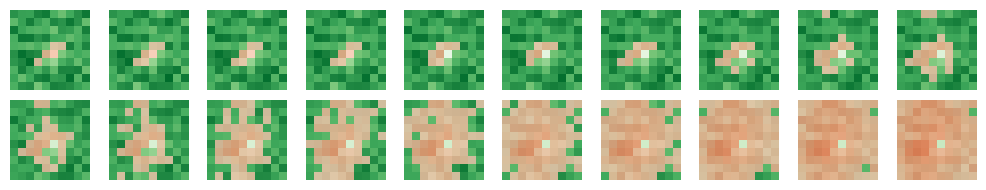

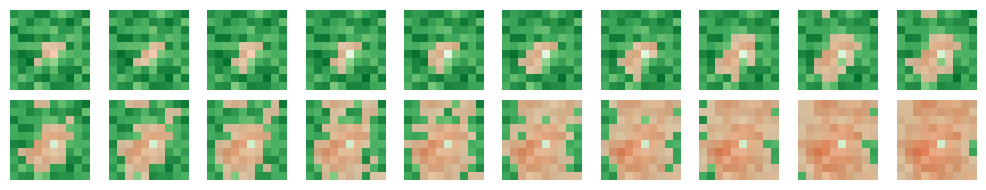

c:\Users\arche\anaconda3\envs\Diss\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


tensor(19.8742, device='cuda:0', dtype=torch.float64)


In [7]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20


Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
plotsequence(Vpred1,Hpred1,predl)
full1 = interveave(Vpred1,Hpred1,size,predl)
Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
plotsequence(Vpred1,Hpred1,predl)
full2 = interveave(Vpred1,Hpred1,size,predl)


full1 = np.expand_dims(full1,axis=0)
full1  = sigkernel.transform(full1, at=True)
full1 = torch.tensor(full1, device='cuda')
full2 = np.expand_dims(full2,axis=0)
full2  = sigkernel.transform(full2, at=True)
full2 = torch.tensor(full2, device='cuda') #dtype

static = sigkernel.Linear_ID_Kernel()
sigker = sigkernel.SigKernel(static, 2)

K = sigker.compute_distance(full1,full2)
print(K)


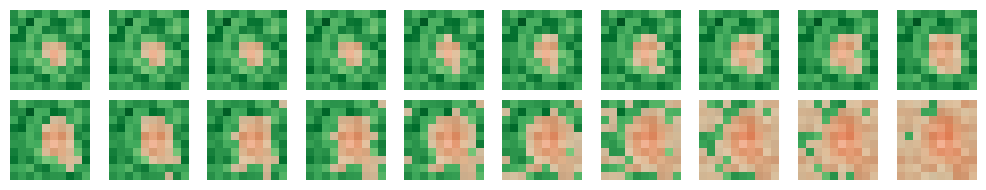

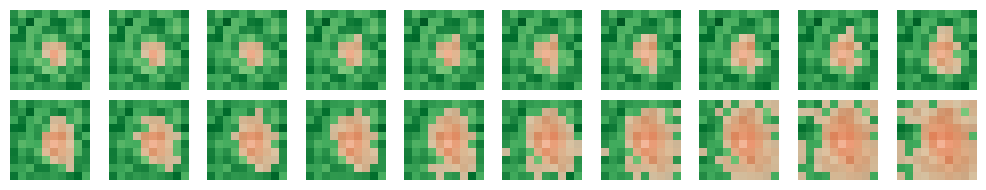

(100, 20, 200)
(50, 20, 200)


NameError: name 'y' is not defined

In [12]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20
simulations = 100
ensmembers = 50

full1sims = np.zeros((simulations,predl,size*size*2))
for i in range(simulations):
    Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
    full1 = interveave(Vpred1,Hpred1,size,predl)
    #full1 = stackblock(Vpred1,Hpred1,size,predl)
    full1sims[i,:,:] = full1
plotsequence(Vpred1,Hpred1,predl)

full2ens = np.zeros((ensmembers,predl,size*size*2))
for i in range(ensmembers):
    Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
    #plotsequence(Vpred1,Hpred1,predl)
    full2 = interveave(Vpred1,Hpred1,size,predl)
    #full2 = stackblock(Vpred1,Hpred1,size,predl)
    full2ens[i,:,:] = full2
plotsequence(Vpred1,Hpred1,predl)

print(full1sims.shape)
print(full2ens.shape)

_1, _2, _3 = full1sims.shape
_11, _22, _33 = full2ens.shape

full1sims = torch.tensor(full1sims, device='cuda')
full2ens = torch.tensor(full2ens, device='cuda') #dtype

zerosX = torch.zeros(_1, 1, _3, device='cuda')
zerosY = torch.zeros(_11, 1, _33, device='cuda')

full1sims = torch.cat([zerosX, full1sims], dim=1)
full2ens = torch.cat([zerosY, full2ens], dim=1)

time_vec = torch.linspace(0, 1, steps=full1sims.shape[1], device='cuda')
# 2) Reshape to match x's batch and sequence dimensions
#    We want [batch_size, seq_len, 1], so we expand along batch dimension
time_vec = time_vec.unsqueeze(0).unsqueeze(-1)  # now [1, seq_len, 1]

y = torch.cat([y, time_vec], dim=-1)
time_vec = time_vec.expand(batch_size, seq_len+1, 1)  # now [batch_size, seq_len, 1]
X = torch.cat([X, time_vec], dim=-1)

X = X.double()
y = y.double()

full1sims  = sigkernel.transform(full1sims, at=True)
full1sims = torch.tensor(full1sims, device='cuda')

full2ens  = sigkernel.transform(full2ens, at=True)
full2ens = torch.tensor(full2ens, device='cuda') #dtype

print(full1sims.shape)
print(full2ens.shape)

static = sigkernel.Linear_ID_Kernel()
sigker = sigkernel.SigKernel(static, 2)

K = sigker.compute_scoring_rule(full2ens,full1sims)
print(K)


In [148]:
np.linspace(-1,1,19)

array([-1.        , -0.88888889, -0.77777778, -0.66666667, -0.55555556,
       -0.44444444, -0.33333333, -0.22222222, -0.11111111,  0.        ,
        0.11111111,  0.22222222,  0.33333333,  0.44444444,  0.55555556,
        0.66666667,  0.77777778,  0.88888889,  1.        ])

In [26]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20
simulations = 100
ensmembers = 50


list = []
length = 19
for change in np.linspace(-1,1,19):
    full1sims = np.zeros((simulations,predl,size*size*2))
    for i in range(simulations):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
        full1 = interveave(Vpred1,Hpred1,size,predl)
        full1sims[i,:,:] = full1
    #plotsequence(Vpred1,Hpred1,predl)

    full2ens = np.zeros((ensmembers,predl,size*size*2))
    for i in range(ensmembers):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b+change,c,d,s,t)
        full2 = interveave(Vpred1,Hpred1,size,predl)
        full2ens[i,:,:] = full2
    #plotsequence(Vpred1,Hpred1,predl)


    # full1sims  = sigkernel.transform(full1sims, at=True)
    # full1sims = torch.tensor(full1sims, device='cuda')

    # full2ens  = sigkernel.transform(full2ens, at=True)
    # full2ens = torch.tensor(full2ens, device='cuda') #dtype

    # print(full1sims.shape)
    # print(full2ens.shape)

    full1sims = torch.tensor(full1sims, device='cuda')
    full2ens = torch.tensor(full2ens, device='cuda') #dtype

    batch_size, seq_len, feature_dim = full2ens.shape
    batch_size1, seq_len1, feature_dim1 = full1sims.shape
    #print(full1sims.shape)

    zerosX = torch.zeros(batch_size, 1, feature_dim, device=full2ens.device)
    zerosY = torch.zeros(batch_size1, 1, feature_dim1, device=full1sims.device)
    #forecast  # Shape: [batch_size, 1, feature_dim]
    X = torch.cat([zerosX, full2ens], dim=1)
    y = torch.cat([zerosY, full1sims], dim=1)

            #1) Create a time vector, shape [seq_len]
    time_vec = torch.linspace(0, 1, steps=seq_len+1, device=full2ens.device)
    # 2) Reshape to match x's batch and sequence dimensions
    #    We want [batch_size, seq_len, 1], so we expand along batch dimension
    time_vec = time_vec.unsqueeze(0).unsqueeze(-1)  # now [1, seq_len, 1]
    
    y = torch.cat([y, time_vec.repeat(batch_size1,1,1)], dim=-1)
    time_vec = time_vec.expand(batch_size, seq_len+1, 1)  # now [batch_size, seq_len, 1]
    X = torch.cat([X, time_vec], dim=-1)

    X = X.double()
    y = y.double()


    static = sigkernel.Linear_ID_Kernel()
    sigker = sigkernel.SigKernel(static, 2)

    K = sigker.compute_expected_scoring_rule(full2ens,full1sims)
    #print(K.item())
    list.append(K.item())

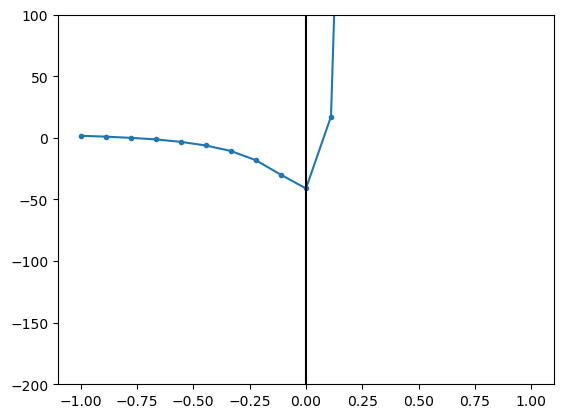

In [17]:
plt.plot(np.linspace(-1,1,19), list, marker = '.')
plt.ylim(-200,100)
plt.axvline(x = 0, color = 'black')
plt.show()

In [8]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20
simulations = 100
ensmembers = 50


list = []
list2 = []
eslist = []
mselist = []
variolist = [] 
length = 59
for change in np.linspace(-1,1,length):
    full1sims = np.zeros((simulations,predl,size*size*2))
    for i in range(simulations):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
        full1 = interveave(Vpred1,Hpred1,size,predl)
        full1sims[i,:,:] = full1
    #plotsequence(Vpred1,Hpred1,predl)

    full2ens = np.zeros((ensmembers,predl,size*size*2))
    for i in range(ensmembers):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b+change,c,d,s,t)
        full2 = interveave(Vpred1,Hpred1,size,predl)
        full2ens[i,:,:] = full2
    #plotsequence(Vpred1,Hpred1,predl)
    es = energy_score(full2ens, full1sims)
    mse = MSE(full2ens,full1sims)
    variogram = variogram_score(full2ens,full1sims)
    print(f"Expected Energy Score: {es:.4f}")

    full1sims = torch.tensor(full1sims, device='cuda')
    full2ens = torch.tensor(full2ens, device='cuda') #dtype

    batch_size, seq_len, feature_dim = full2ens.shape
    batch_size1, seq_len1, feature_dim1 = full1sims.shape
    #print(full1sims.shape)

    zerosX = torch.zeros(batch_size, 1, feature_dim, device=full2ens.device)
    zerosY = torch.zeros(batch_size1, 1, feature_dim1, device=full1sims.device)
    #forecast  # Shape: [batch_size, 1, feature_dim]
    X = torch.cat([zerosX, full2ens], dim=1)
    y = torch.cat([zerosY, full1sims], dim=1)

            #1) Create a time vector, shape [seq_len]
    time_vec = torch.linspace(0, 1, steps=seq_len+1, device=full2ens.device)
    # 2) Reshape to match x's batch and sequence dimensions
    #    We want [batch_size, seq_len, 1], so we expand along batch dimension
    time_vec = time_vec.unsqueeze(0).unsqueeze(-1)  # now [1, seq_len, 1]
    
    y = torch.cat([y, time_vec.repeat(batch_size1,1,1)], dim=-1)
    time_vec = time_vec.expand(batch_size, seq_len+1, 1)  # now [batch_size, seq_len, 1]
    X = torch.cat([X, time_vec], dim=-1)

    X = X.double()
    y = y.double()

    static = sigkernel.RBFKernel(sigma=1)
    sigker = sigkernel.SigKernel(static, 1)

    K = sigker.compute_scoring_rule(full2ens,full1sims)

    static1 = sigkernel.Linear_ID_Kernel()
    sigker1 = sigkernel.SigKernel(static1, 1)

    K1 = sigker1.compute_scoring_rule(full2ens,full1sims)
    # if change == 0:
    #     print(change)
    # print(K.item())
    list.append(K.item())
    list2.append(K1.item())
    eslist.append(es)
    mselist.append(mse)
    variolist.append(variogram)

Expected Energy Score: 1.3284
Expected Energy Score: 1.2985
Expected Energy Score: 1.2681
Expected Energy Score: 1.2588
Expected Energy Score: 1.2247
Expected Energy Score: 1.2074
Expected Energy Score: 1.1806
Expected Energy Score: 1.1587
Expected Energy Score: 1.1331
Expected Energy Score: 1.0913
Expected Energy Score: 1.0744
Expected Energy Score: 1.0297
Expected Energy Score: 1.0019
Expected Energy Score: 0.9553
Expected Energy Score: 0.9181
Expected Energy Score: 0.8811
Expected Energy Score: 0.8334
Expected Energy Score: 0.7881
Expected Energy Score: 0.7398
Expected Energy Score: 0.6931
Expected Energy Score: 0.6471
Expected Energy Score: 0.5879
Expected Energy Score: 0.5373
Expected Energy Score: 0.4881
Expected Energy Score: 0.4476
Expected Energy Score: 0.3939
Expected Energy Score: 0.3428
Expected Energy Score: 0.3103
Expected Energy Score: 0.2786
Expected Energy Score: 0.2678
Expected Energy Score: 0.2788
Expected Energy Score: 0.3135
Expected Energy Score: 0.3729
Expected E

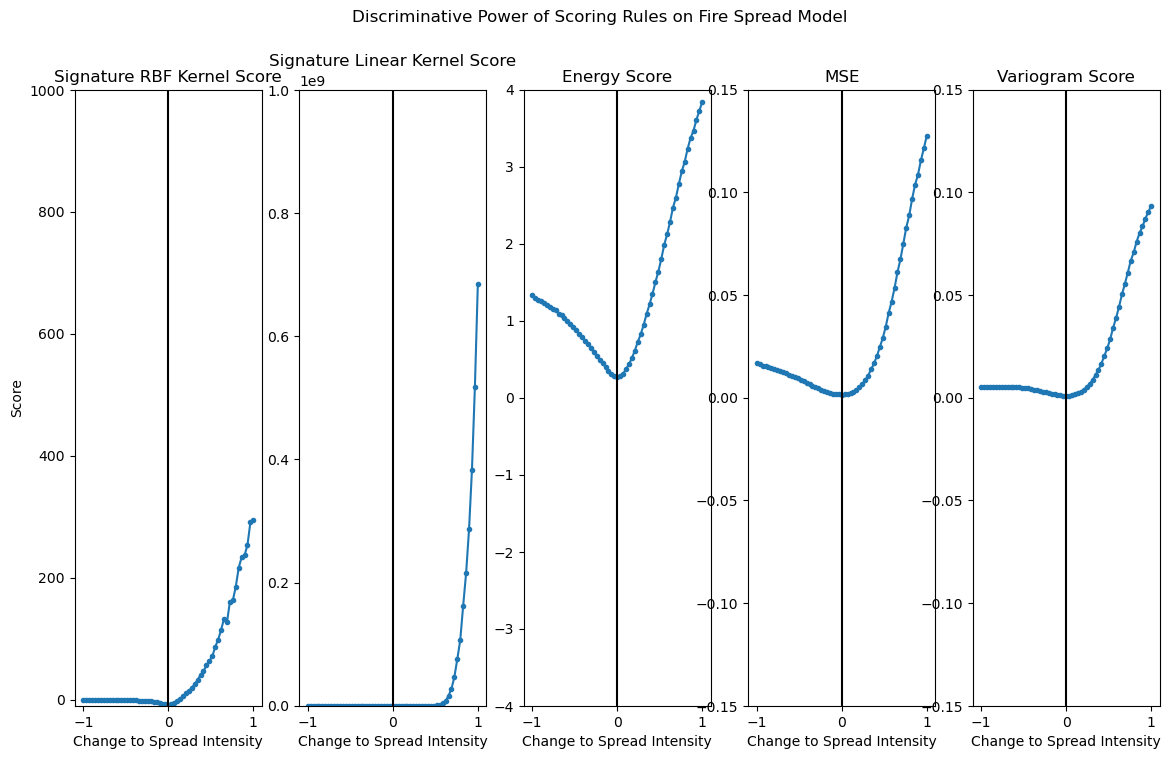

In [41]:
fig, axs = plt.subplots(1, 5, figsize=(14, 8))
plt.rcParams.update({'font.size': 10})
plt.subplot(1,5,1)
axs[0].set_xlabel('Change to Spread Intensity')
plt.plot(np.linspace(-1,1,length), list, marker = '.')
plt.ylim(-10,1000)
plt.axvline(x = 0, color = 'black')
plt.title(label="Signature RBF Kernel Score")

plt.subplot(1,5,2)
axs[1].set_xlabel('Change to Spread Intensity')
plt.plot(np.linspace(-1,1,length), list2, marker = '.')
plt.ylim(-10,1000000000)
plt.axvline(x = 0, color = 'black')
plt.title(label="Signature Linear Kernel Score")

plt.subplot(1,5,3)
plt.plot(np.linspace(-1,1,length), eslist, marker = '.')
plt.ylim(-4,4)
plt.axvline(x = 0, color = 'black')
plt.title(label="Energy Score")
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model")
axs[2].set_xlabel('Change to Spread Intensity')

plt.subplot(1,5,4)
plt.plot(np.linspace(-1,1,length), mselist, marker = '.')
plt.ylim(-0.15,0.15)
plt.axvline(x = 0, color = 'black')
plt.title(label="MSE")
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model")
axs[3].set_xlabel('Change to Spread Intensity')

plt.subplot(1,5,5)
plt.plot(np.linspace(-1,1,length), variolist, marker = '.')
plt.ylim(-0.15,0.15)
plt.axvline(x = 0, color = 'black')
plt.title(label="Variogram Score")
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model")
axs[0].set_ylabel('Score')
axs[4].set_xlabel('Change to Spread Intensity')

plt.show()


59

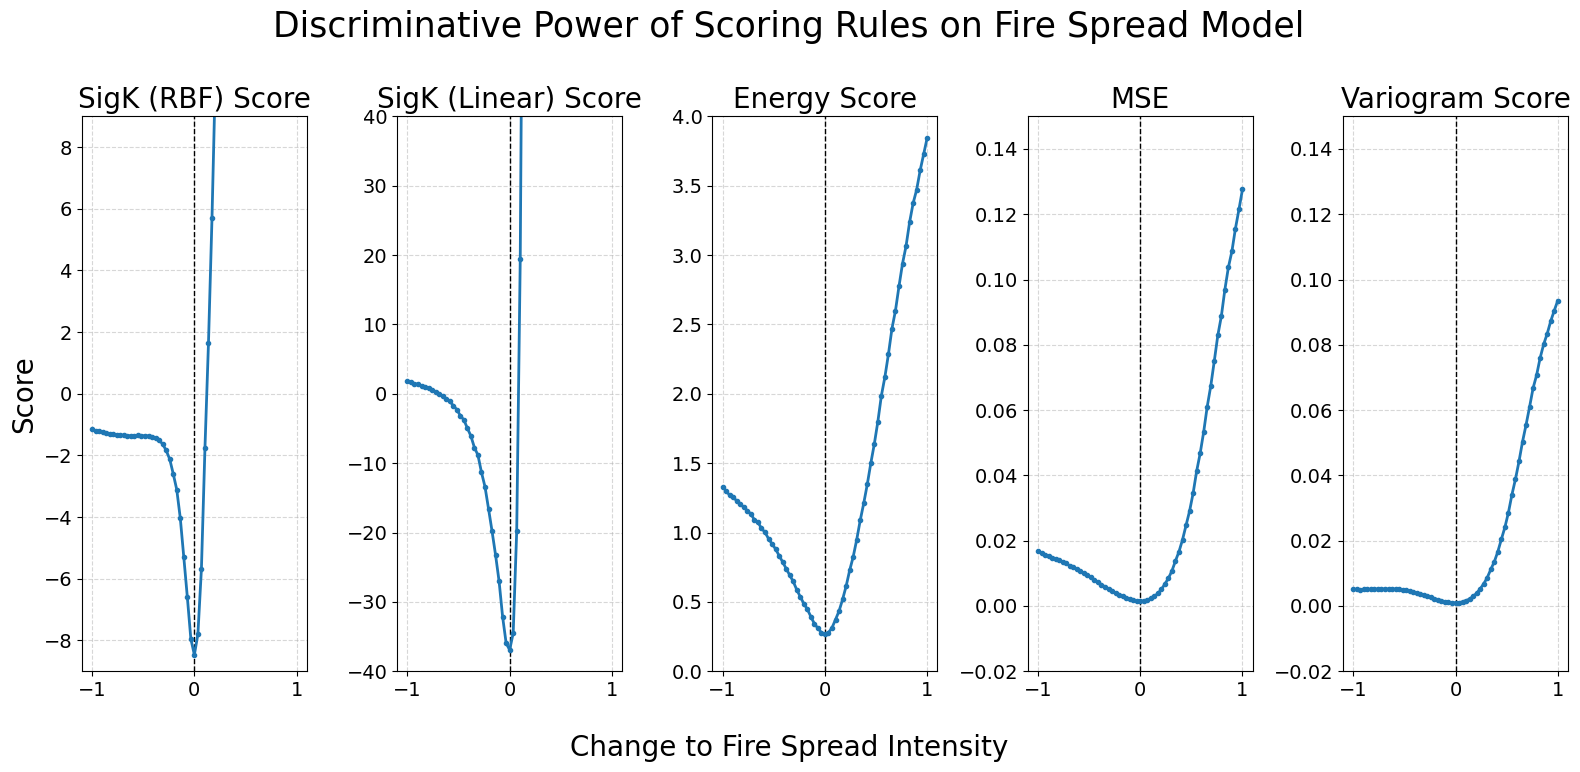

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace these with your actual arrays)
length = 59
x = np.linspace(-1, 1, 59)
signature_scores = list
signature_scores2 = list2
energy_scores    = eslist
mse_scores       = mselist
variogram_scores = variolist

# Increase global font sizes for readability
plt.rcParams.update({'font.size': 14})

# Create a 1x4 grid of subplots with a larger figure size for slides
fig, axs = plt.subplots(1, 5, figsize=(16, 8))

# Define common properties
titles = ["SigK (RBF) Score", "SigK (Linear) Score", "Energy Score", "MSE", "Variogram Score"]
y_limits = [(-9, 9), (-40, 40), (0, 4), (-0.02, 0.15), (-0.02, 0.15)]
x_label = "Change to Fire Spread Intensity"
y_label = "Score"

for i, ax in enumerate(axs):
    if i == 0:
        # Only the first subplot gets a y-axis label
        ax.set_ylabel(y_label,  fontsize=20)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(y_limits[i])
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(titles[i], fontsize=20)
fig.supxlabel(x_label, fontsize=20)
    
# Plot each line with markers
axs[0].plot(x, signature_scores, marker='.', linewidth=2)
axs[1].plot(x, signature_scores2, marker='.', linewidth=2)
axs[2].plot(x, energy_scores, marker='.', linewidth=2)
axs[3].plot(x, mse_scores, marker='.', linewidth=2)
axs[4].plot(x, variogram_scores, marker='.', linewidth=2)

# Overall figure title
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model", fontsize=25, y=0.95)

# Adjust layout to prevent overlap and leave room for the title
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Example data (replace these with your actual arrays)
length = 59
x = np.linspace(-1, 1, 59)
signature_scores = list3
signature_scores2 = list4
energy_scores    = eslist1
mse_scores       = mselist1
variogram_scores = variolist1

# Increase global font sizes for readability
plt.rcParams.update({'font.size': 14})

# Create a 1x4 grid of subplots with a larger figure size for slides
fig, axs = plt.subplots(1, 5, figsize=(16, 8))

# Define common properties
titles = ["SigK (RBF) Score", "SigK (Linear) Score", "Energy Score", "MSE", "Variogram Score"]
y_limits = [(-12, 12), (-60, 15), (0.2, 0.7), (0, 0.005), (0, 0.0025)]
x_label = "Change to Vegetation Growth"
y_label = "Score"

for i, ax in enumerate(axs):
    if i == 0:
        # Only the first subplot gets a y-axis label
        ax.set_ylabel(y_label,  fontsize=20)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(y_limits[i])
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(titles[i], fontsize=20)
fig.supxlabel(x_label, fontsize=20)
    
# Plot each line with markers
axs[0].plot(x, signature_scores, marker='.', linewidth=2)
axs[1].plot(x, signature_scores2, marker='.', linewidth=2)
axs[2].plot(x, energy_scores, marker='.', linewidth=2)
axs[3].plot(x, mse_scores, marker='.', linewidth=2)
axs[4].plot(x, variogram_scores, marker='.', linewidth=2)

# Overall figure title
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model", fontsize=25, y=0.95)

# Adjust layout to prevent overlap and leave room for the title
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



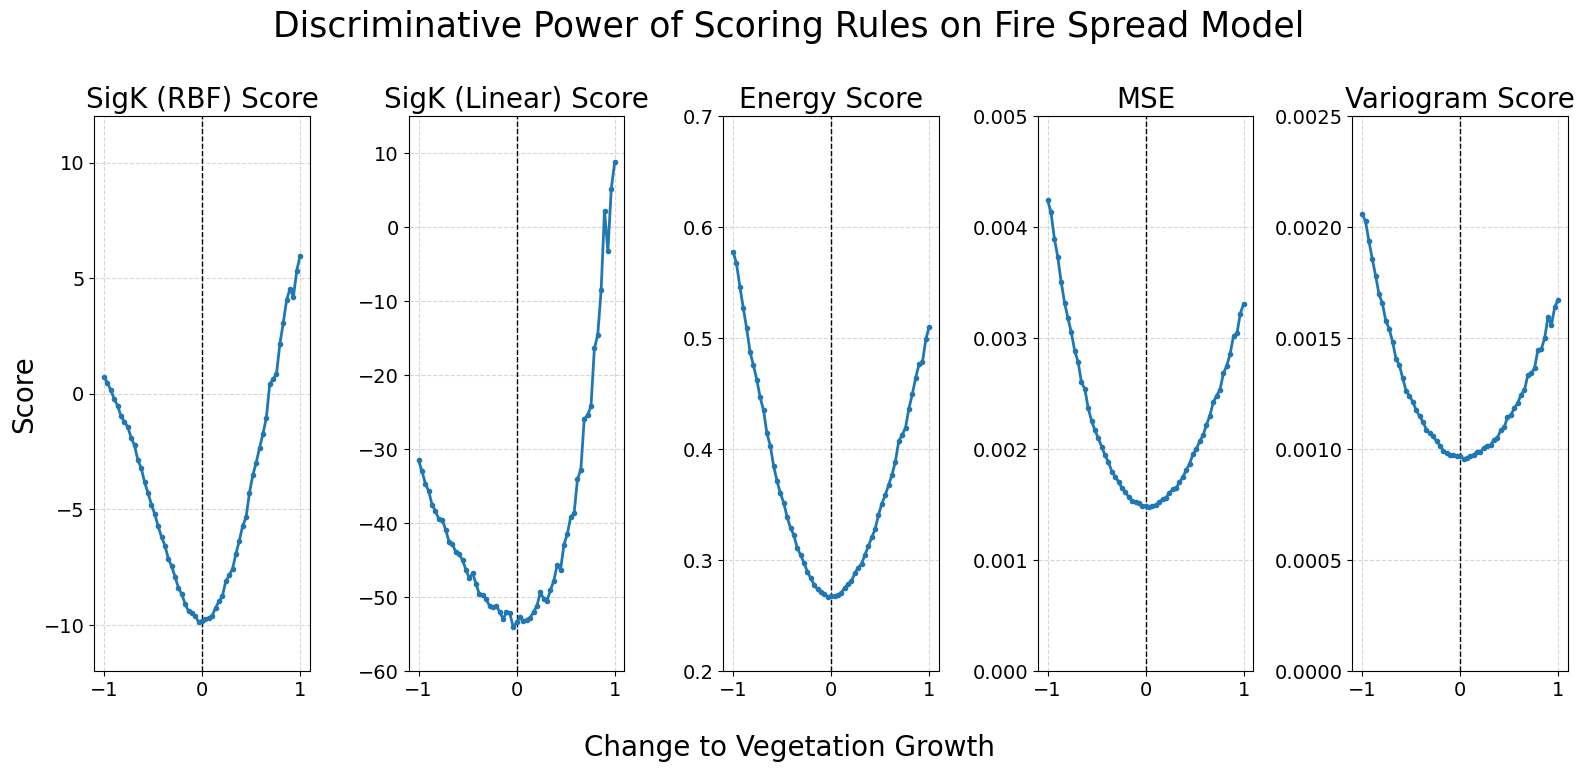

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace these with your actual arrays)
length = 59
x = np.linspace(-1, 1, 59)
signature_scores = list3
signature_scores2 = list4
energy_scores    = eslist1
mse_scores       = mselist1
variogram_scores = variolist1

# Increase global font sizes for readability
plt.rcParams.update({'font.size': 14})

# Create a 1x4 grid of subplots with a larger figure size for slides
fig, axs = plt.subplots(1, 5, figsize=(16, 8))

# Define common properties
titles = ["SigK (RBF) Score", "SigK (Linear) Score", "Energy Score", "MSE", "Variogram Score"]
y_limits = [(-12, 12), (-60, 15), (0.2, 0.7), (0, 0.005), (0, 0.0025)]
x_label = "Change to Vegetation Growth"
y_label = "Score"

for i, ax in enumerate(axs):
    if i == 0:
        # Only the first subplot gets a y-axis label
        ax.set_ylabel(y_label,  fontsize=20)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(y_limits[i])
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(titles[i], fontsize=20)
fig.supxlabel(x_label, fontsize=20)
    
# Plot each line with markers
axs[0].plot(x, signature_scores, marker='.', linewidth=2)
axs[1].plot(x, signature_scores2, marker='.', linewidth=2)
axs[2].plot(x, energy_scores, marker='.', linewidth=2)
axs[3].plot(x, mse_scores, marker='.', linewidth=2)
axs[4].plot(x, variogram_scores, marker='.', linewidth=2)

# Overall figure title
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model", fontsize=25, y=0.95)

# Adjust layout to prevent overlap and leave room for the title
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


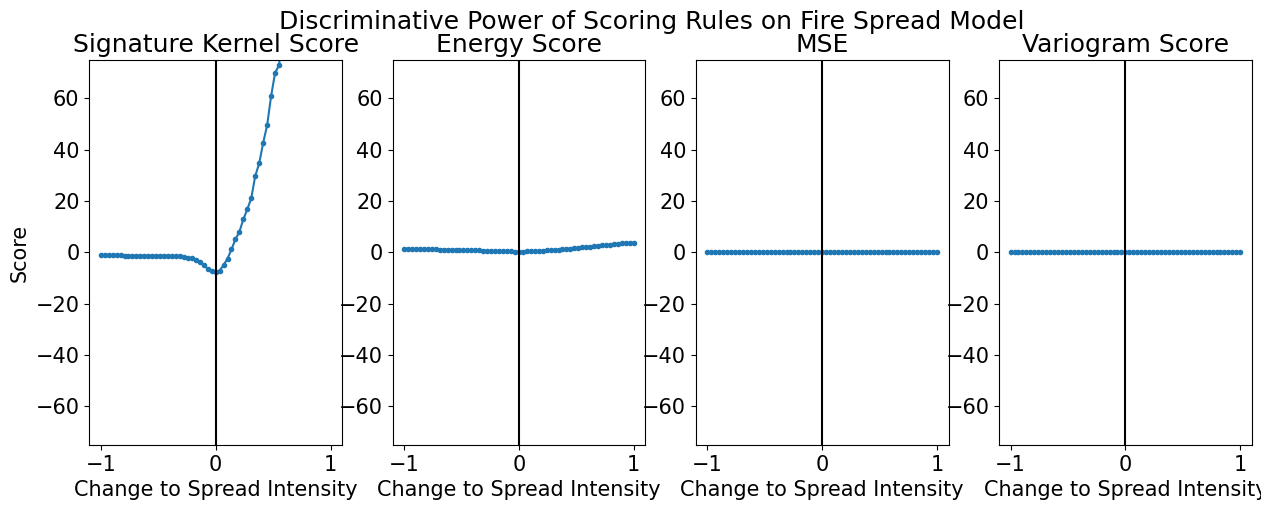

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
plt.subplot(1,4,1)
axs[0].set_xlabel('Change to Spread Intensity')
plt.plot(np.linspace(-1,1,length), list, marker = '.')
plt.ylim(-75,75)
plt.axvline(x = 0, color = 'black')
plt.title(label="Signature Kernel Score")

plt.subplot(1,4,2)
plt.plot(np.linspace(-1,1,length), eslist, marker = '.')
plt.ylim(-75,75)
plt.axvline(x = 0, color = 'black')
plt.title(label="Energy Score")
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model")
axs[1].set_xlabel('Change to Spread Intensity')

plt.subplot(1,4,3)
plt.plot(np.linspace(-1,1,length), mselist, marker = '.')
plt.ylim(-75,75)
plt.axvline(x = 0, color = 'black')
plt.title(label="MSE")
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model")
axs[2].set_xlabel('Change to Spread Intensity')

plt.subplot(1,4,4)
plt.plot(np.linspace(-1,1,length), variolist, marker = '.')
plt.ylim(-75,75)
plt.axvline(x = 0, color = 'black')
plt.title(label="Variogram Score")
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model")
axs[0].set_ylabel('Score')
axs[3].set_xlabel('Change to Spread Intensity')

plt.show()


In [31]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20
simulations = 200
ensmembers = 50


list3 = []
list4 = []
eslist1 = []
mselist1 = []
variolist1 = [] 
length = 59
for change in np.linspace(-0.09,0.09,length):
    full1sims = np.zeros((simulations,predl,size*size*2))
    for i in range(simulations):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
        full1 = interveave(Vpred1,Hpred1,size,predl)
        full1sims[i,:,:] = full1
    #plotsequence(Vpred1,Hpred1,predl)

    full2ens = np.zeros((ensmembers,predl,size*size*2))
    for i in range(ensmembers):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a+change,b,c,d,s,t)
        full2 = interveave(Vpred1,Hpred1,size,predl)
        full2ens[i,:,:] = full2
    #plotsequence(Vpred1,Hpred1,predl)
    es = energy_score(full2ens, full1sims)
    mse = MSE(full2ens,full1sims)
    variogram = variogram_score(full2ens,full1sims)
    print(f"Expected Energy Score: {es:.4f}")

    full1sims  = sigkernel.transform(full1sims, at=True)
    full1sims = torch.tensor(full1sims, device='cuda')

    full2ens  = sigkernel.transform(full2ens, at=True)
    full2ens = torch.tensor(full2ens, device='cuda') #dtype

    #print(full1sims.shape)
    #print(full2ens.shape)

    static = sigkernel.RBFKernel(sigma=1)
    sigker = sigkernel.SigKernel(static, 1)

    K = sigker.compute_scoring_rule(full2ens,full1sims)

    static1 = sigkernel.Linear_ID_Kernel()
    sigker1 = sigkernel.SigKernel(static1, 1)

    K1 = sigker1.compute_scoring_rule(full2ens,full1sims)
    # if change == 0:
    #     print(change)
    # print(K.item())
    list3.append(K.item())
    list4.append(K1.item())
    eslist1.append(es)
    mselist1.append(mse)
    variolist1.append(variogram)

Expected Energy Score: 0.5781
Expected Energy Score: 0.5675
Expected Energy Score: 0.5466
Expected Energy Score: 0.5275
Expected Energy Score: 0.5090
Expected Energy Score: 0.4880
Expected Energy Score: 0.4758
Expected Energy Score: 0.4628
Expected Energy Score: 0.4468
Expected Energy Score: 0.4352
Expected Energy Score: 0.4144
Expected Energy Score: 0.4033
Expected Energy Score: 0.3847
Expected Energy Score: 0.3713
Expected Energy Score: 0.3602
Expected Energy Score: 0.3515
Expected Energy Score: 0.3386
Expected Energy Score: 0.3291
Expected Energy Score: 0.3224
Expected Energy Score: 0.3107
Expected Energy Score: 0.3047
Expected Energy Score: 0.2975
Expected Energy Score: 0.2895
Expected Energy Score: 0.2837
Expected Energy Score: 0.2777
Expected Energy Score: 0.2737
Expected Energy Score: 0.2711
Expected Energy Score: 0.2694
Expected Energy Score: 0.2674
Expected Energy Score: 0.2676
Expected Energy Score: 0.2677
Expected Energy Score: 0.2688
Expected Energy Score: 0.2706
Expected E

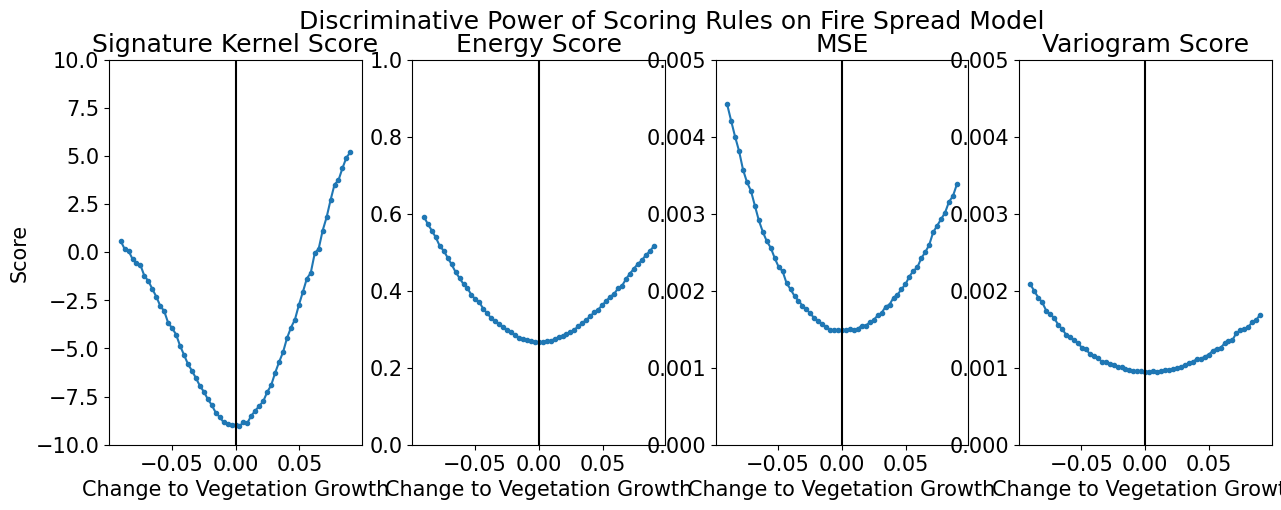

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
plt.subplot(1,4,1)
axs[0].set_xlabel('Change to Vegetation Growth')
plt.plot(np.linspace(-0.09,0.09,length), list1, marker = '.')
plt.ylim(-10,10)
plt.axvline(x = 0, color = 'black')
plt.title(label="Signature Kernel Score")

plt.subplot(1,4,2)
plt.plot(np.linspace(-0.09,0.09,length), eslist1, marker = '.')
plt.ylim(0,1)
plt.axvline(x = 0, color = 'black')
plt.title(label="Energy Score")
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model")
axs[1].set_xlabel('Change to Vegetation Growth')

plt.subplot(1,4,3)
plt.plot(np.linspace(-0.09,0.09,length), mselist1, marker = '.')
plt.ylim(0,0.005)
plt.axvline(x = 0, color = 'black')
plt.title(label="MSE")
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model")
axs[2].set_xlabel('Change to Vegetation Growth')

plt.subplot(1,4,4)
plt.plot(np.linspace(-0.09,0.09,length), variolist1, marker = '.')
plt.ylim(0,0.005)
plt.axvline(x = 0, color = 'black')
plt.title(label="Variogram Score")
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model")
axs[0].set_ylabel('Score')
axs[3].set_xlabel('Change to Vegetation Growth')

plt.show()

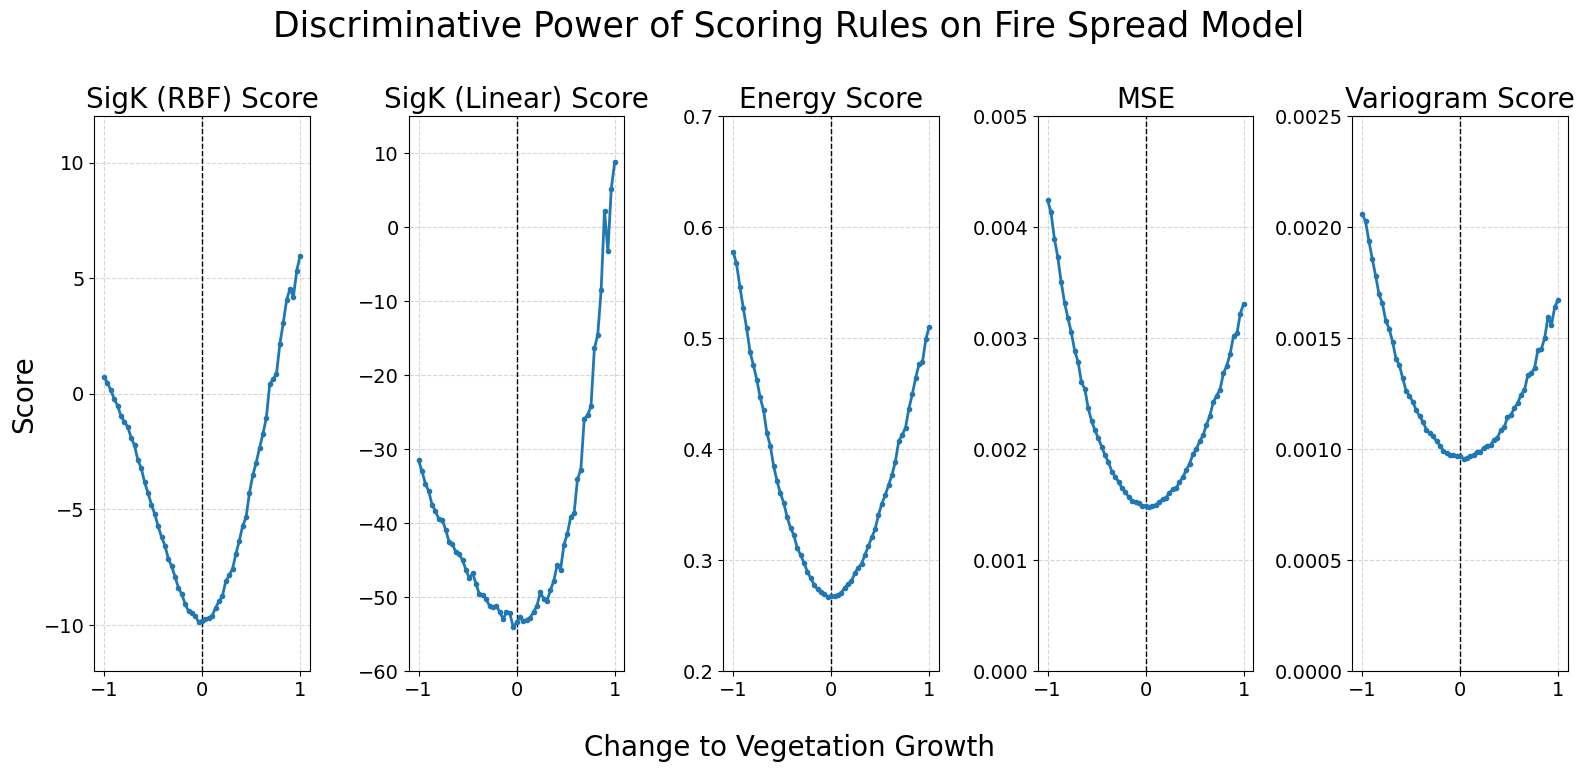

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace these with your actual arrays)
length = 59
x = np.linspace(-1, 1, 59)
signature_scores = list3
signature_scores2 = list4
energy_scores    = eslist1
mse_scores       = mselist1
variogram_scores = variolist1

# Increase global font sizes for readability
plt.rcParams.update({'font.size': 14})

# Create a 1x4 grid of subplots with a larger figure size for slides
fig, axs = plt.subplots(1, 5, figsize=(16, 8))

# Define common properties
titles = ["SigK (RBF) Score", "SigK (Linear) Score", "Energy Score", "MSE", "Variogram Score"]
y_limits = [(-12, 12), (-60, 15), (0.2, 0.7), (0, 0.005), (0, 0.0025)]
x_label = "Change to Vegetation Growth"
y_label = "Score"

for i, ax in enumerate(axs):
    if i == 0:
        # Only the first subplot gets a y-axis label
        ax.set_ylabel(y_label,  fontsize=20)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_ylim(y_limits[i])
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(titles[i], fontsize=20)
fig.supxlabel(x_label, fontsize=20)
    
# Plot each line with markers
axs[0].plot(x, signature_scores, marker='.', linewidth=2)
axs[1].plot(x, signature_scores2, marker='.', linewidth=2)
axs[2].plot(x, energy_scores, marker='.', linewidth=2)
axs[3].plot(x, mse_scores, marker='.', linewidth=2)
axs[4].plot(x, variogram_scores, marker='.', linewidth=2)

# Overall figure title
plt.suptitle("Discriminative Power of Scoring Rules on Fire Spread Model", fontsize=25, y=0.95)

# Adjust layout to prevent overlap and leave room for the title
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


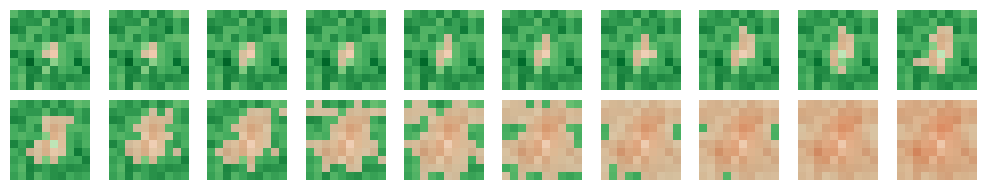

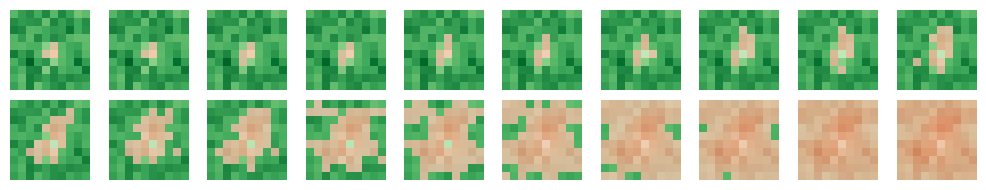

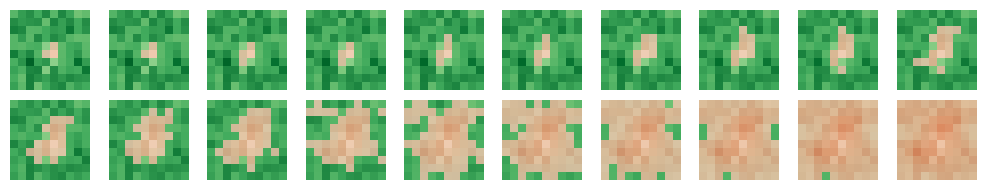

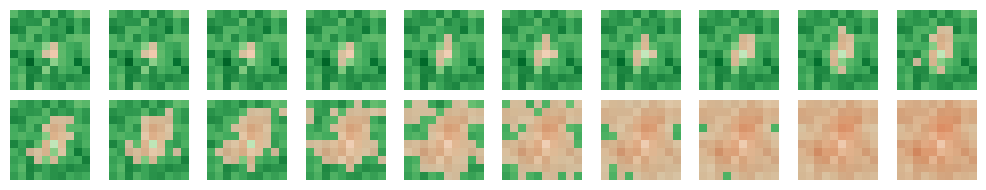

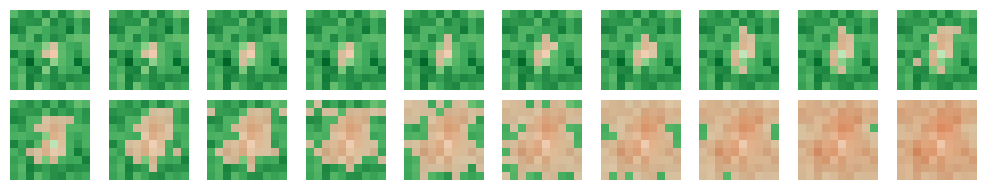

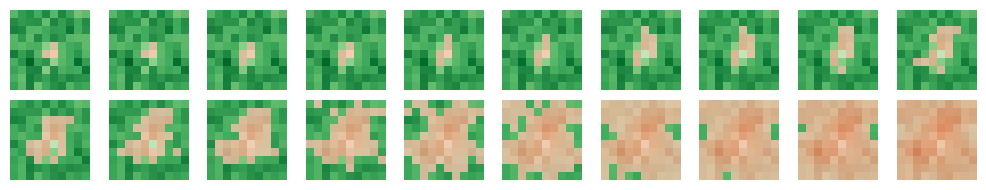

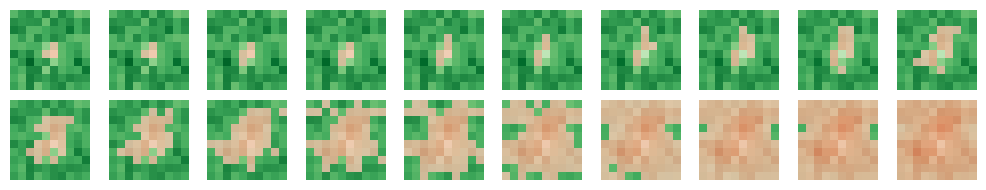

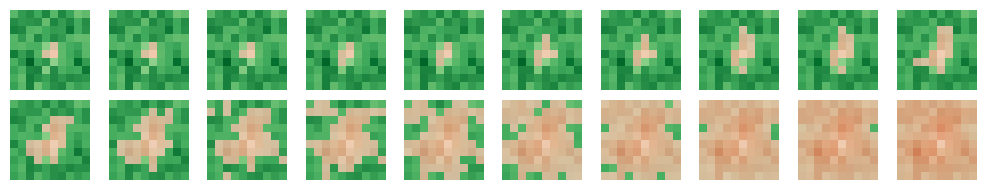

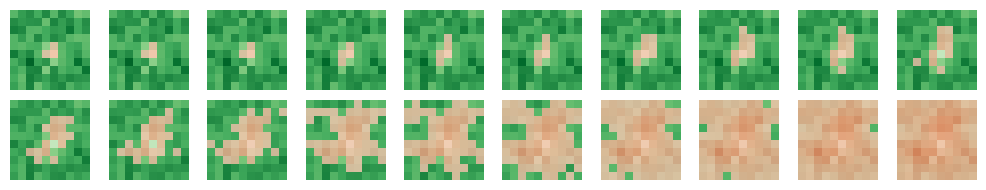

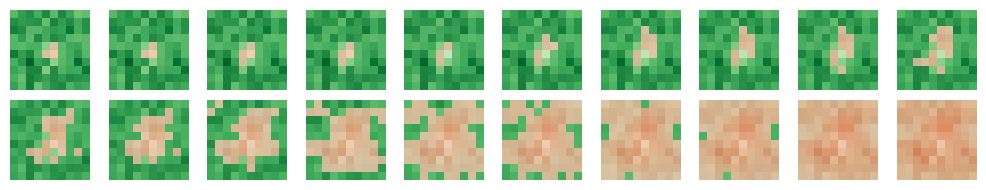

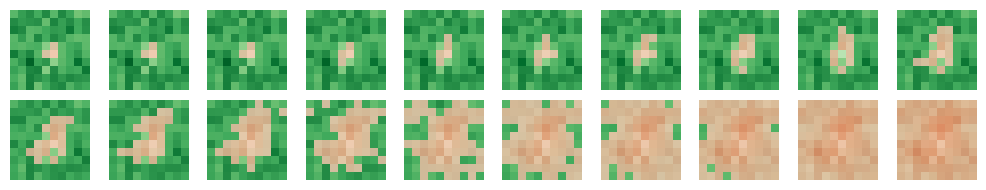

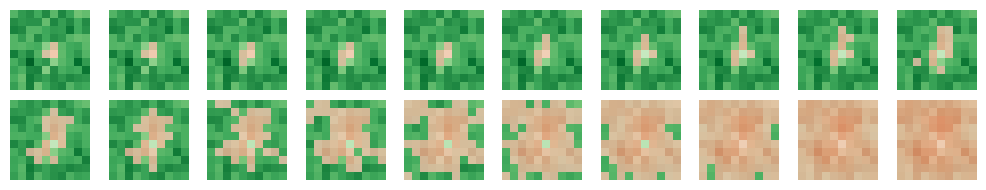

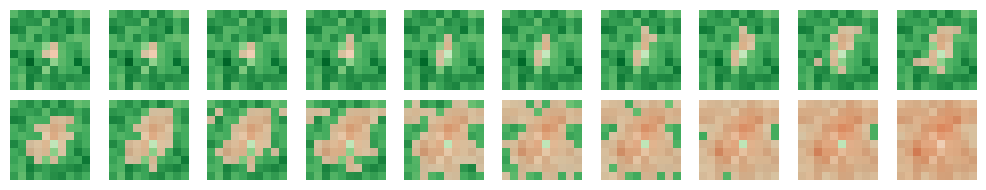

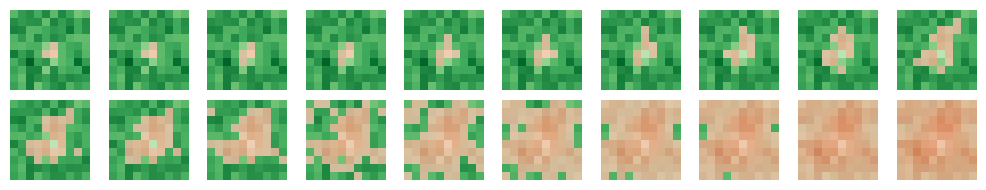

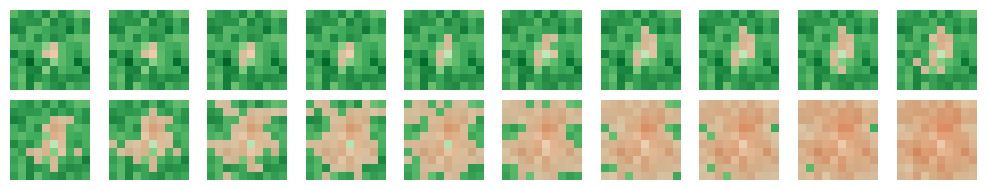

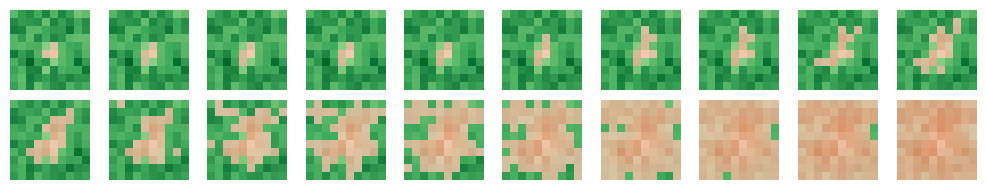

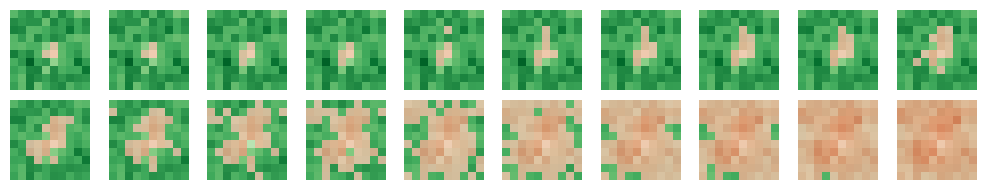

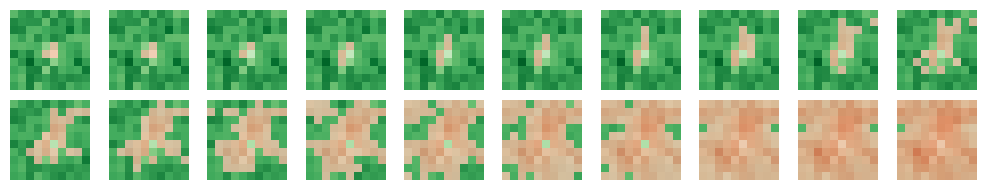

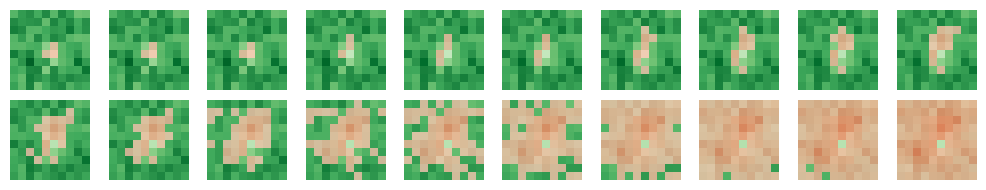

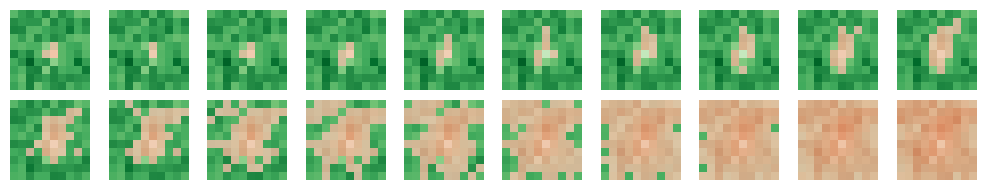

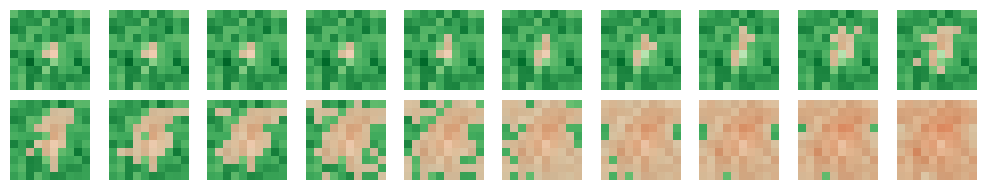

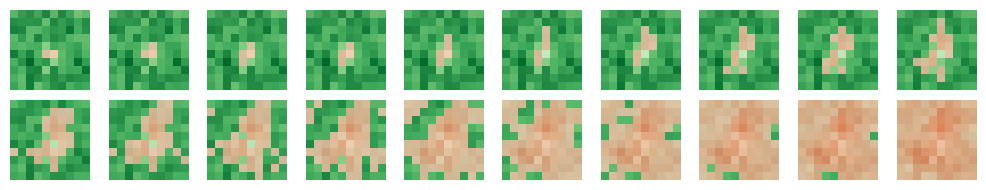

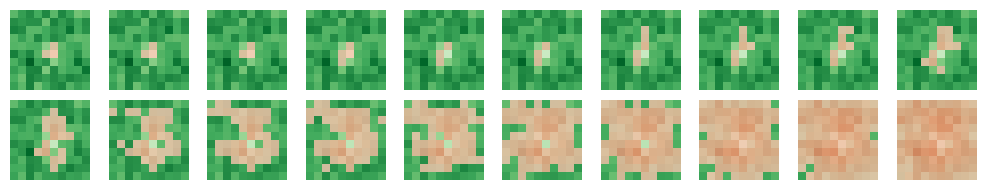

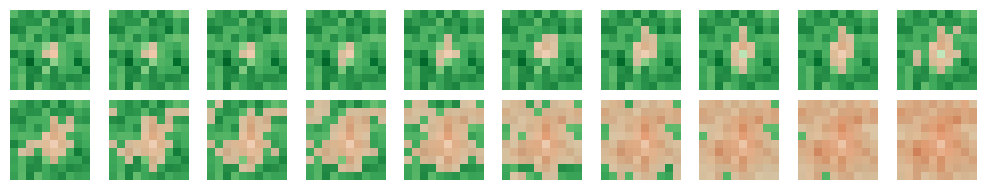

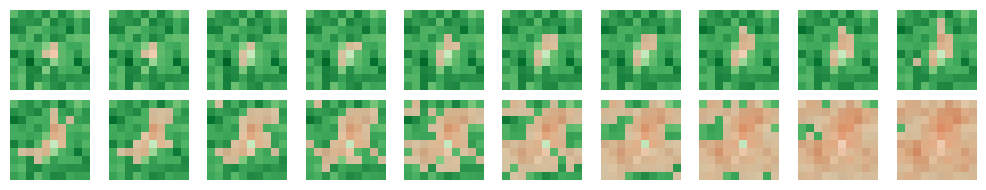

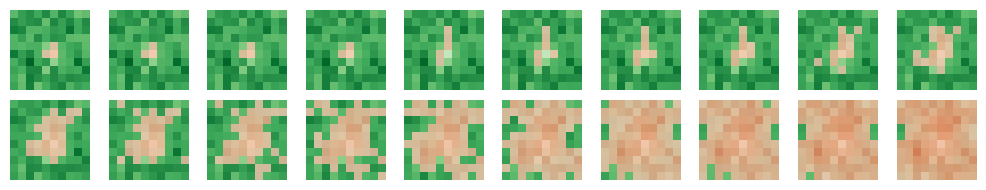

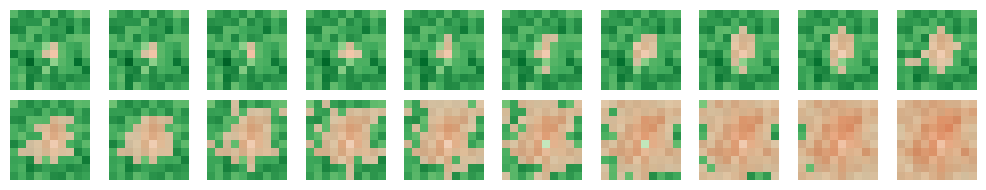

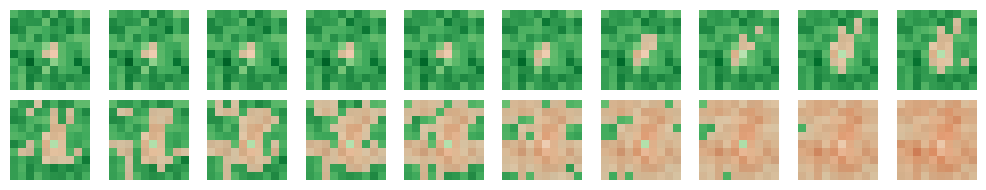

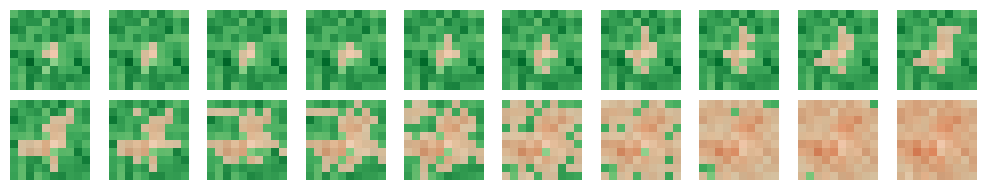

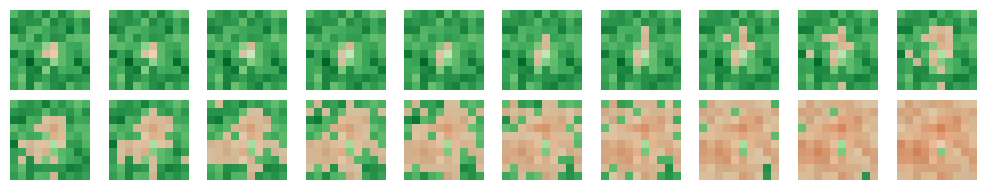

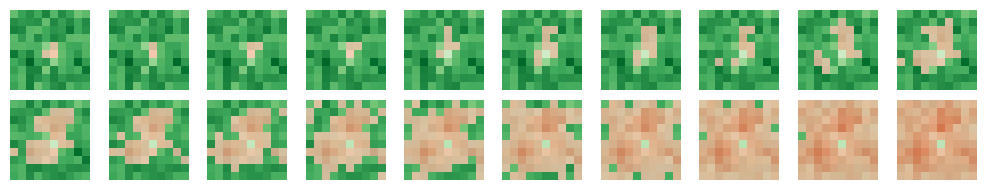

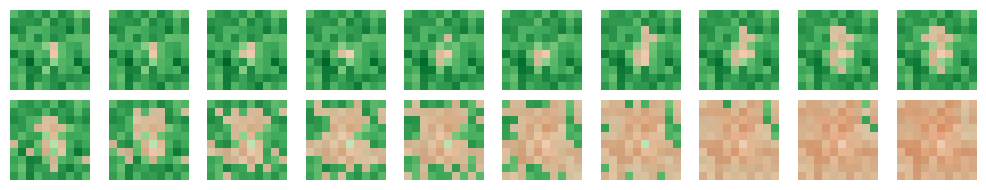

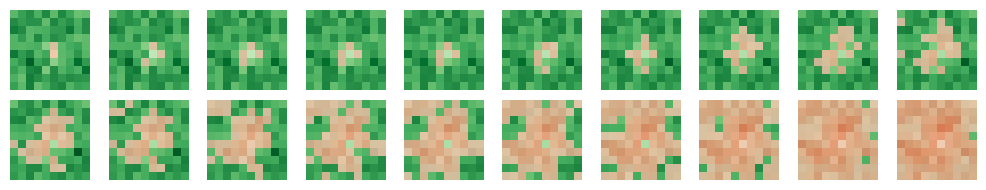

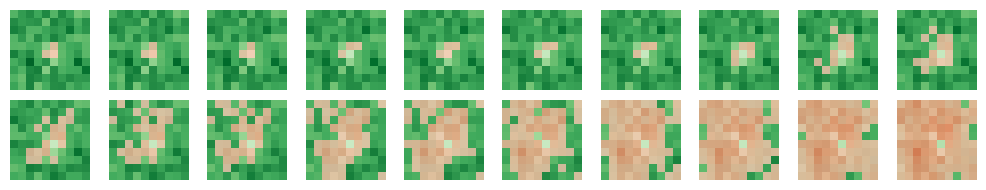

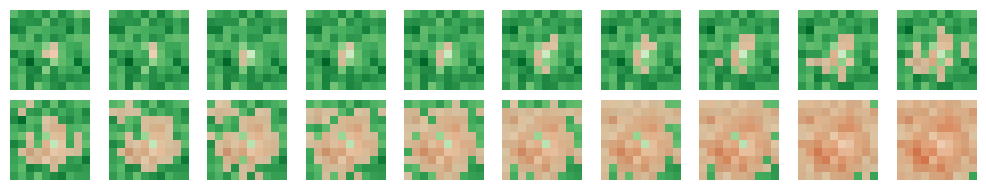

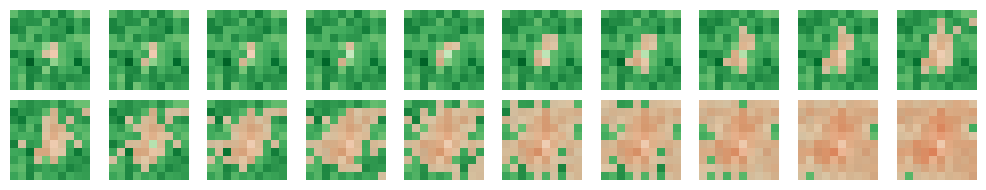

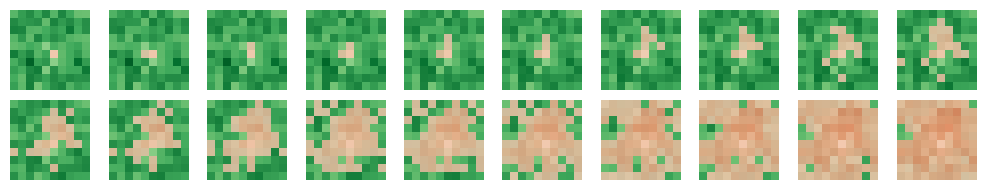

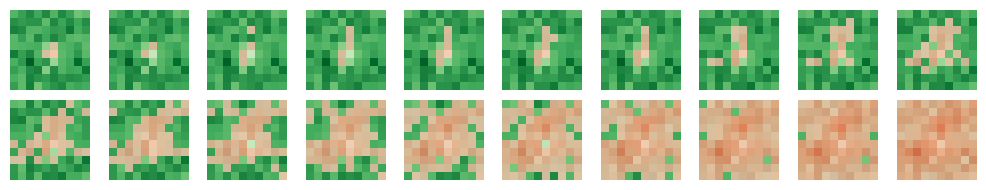

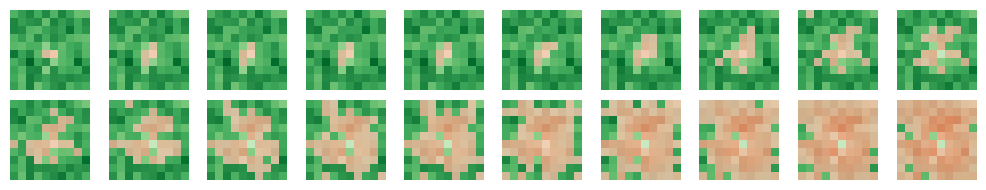

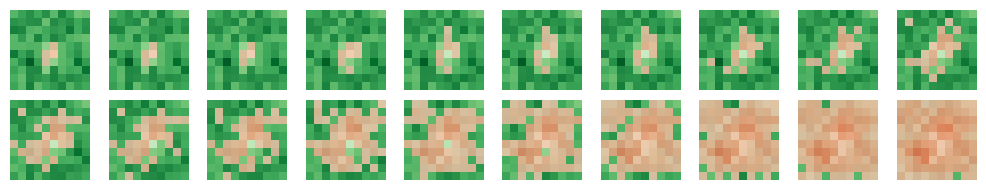

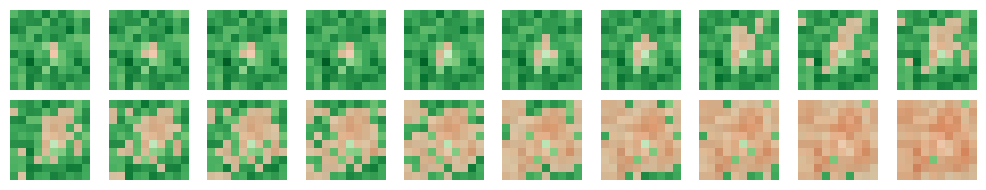

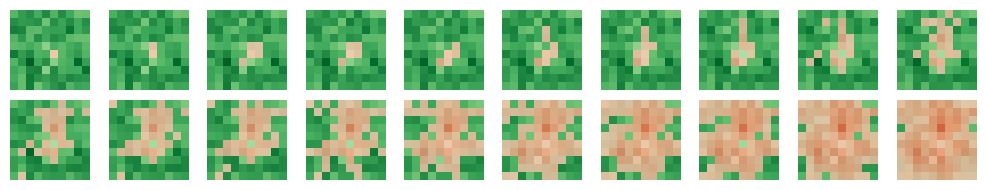

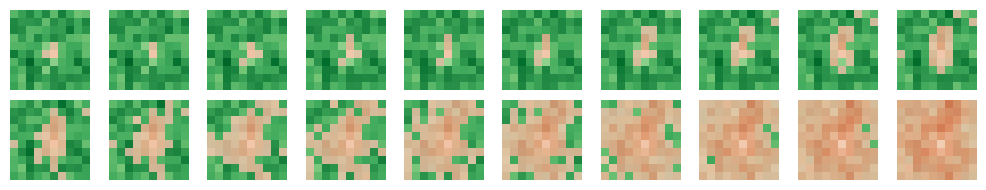

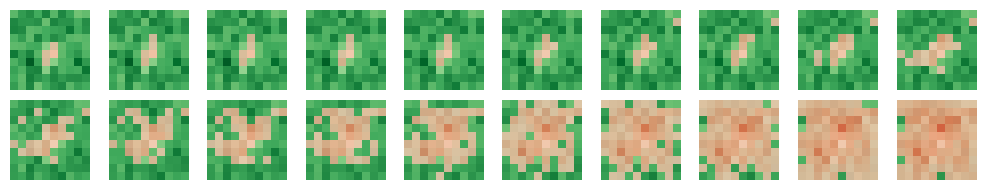

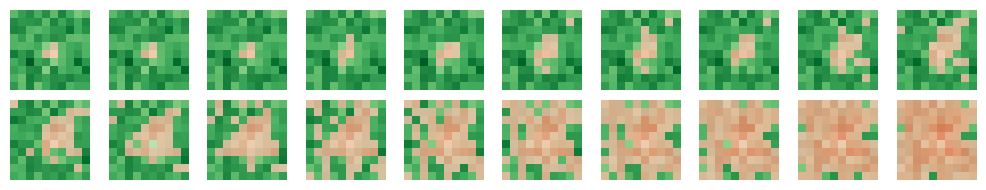

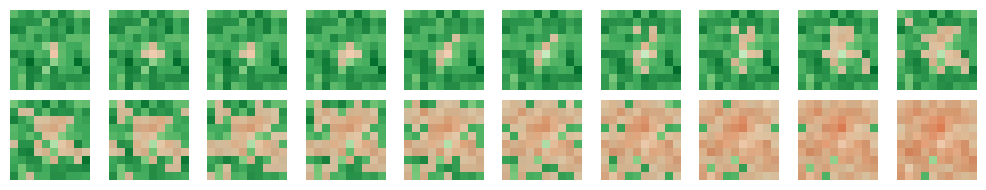

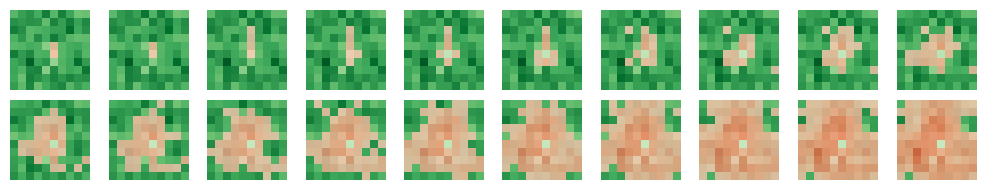

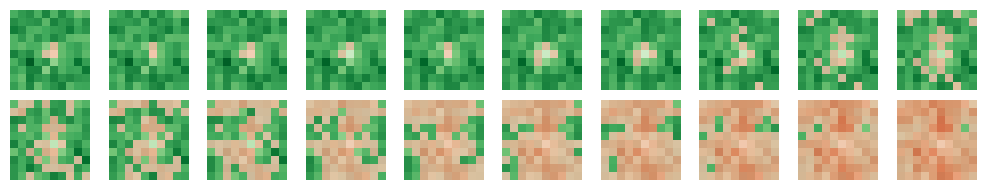

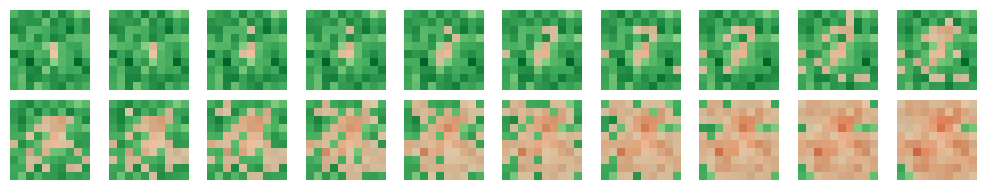

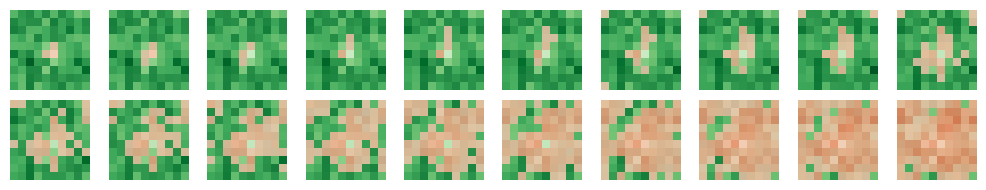

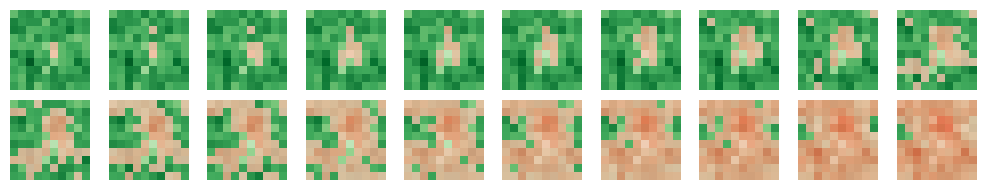

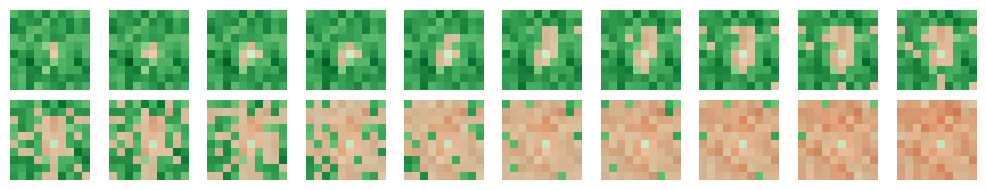

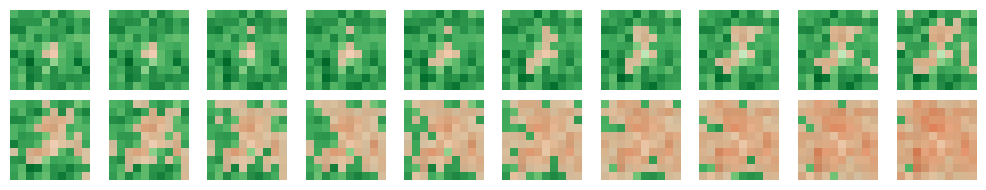

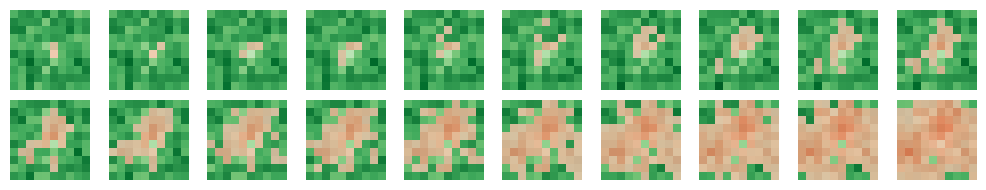

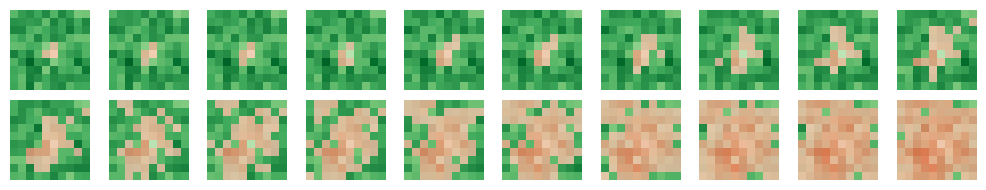

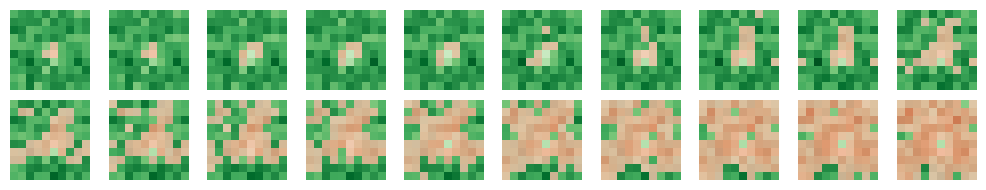

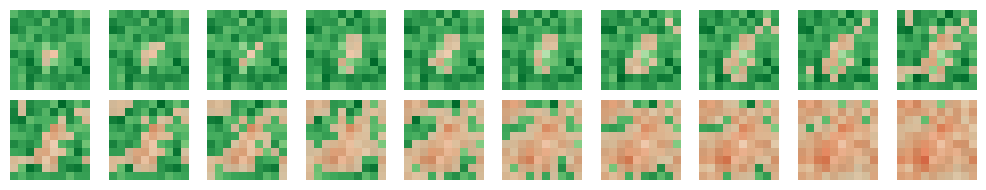

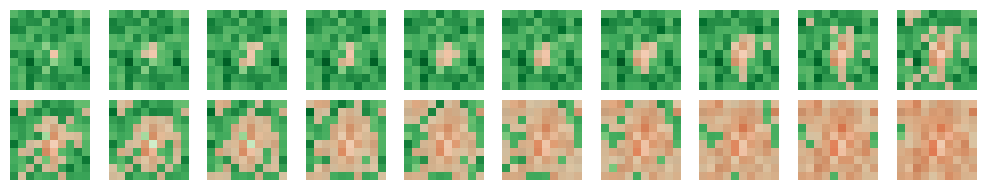

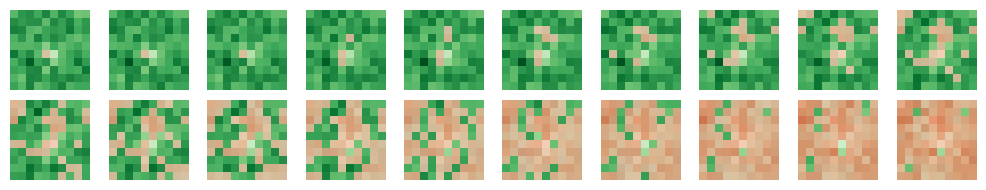

In [50]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20
simulations = 100
ensmembers = 50


list = []
eslist = []
length = 59
for change in np.linspace(-0.009,0.009,length):
    full1sims = np.zeros((simulations,predl,size*size*2))
    for i in range(simulations):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
        full1 = interveave(Vpred1,Hpred1,size,predl)
        full1sims[i,:,:] = full1
    #plotsequence(Vpred1,Hpred1,predl)

    full2ens = np.zeros((ensmembers,predl,size*size*2))
    for i in range(ensmembers):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s+change,t)
        full2 = interveave(Vpred1,Hpred1,size,predl)
        full2ens[i,:,:] = full2
    plotsequence(Vpred1,Hpred1,predl)
    es = energy_score(full2ens, full1sims)
    #print(f"Expected Energy Score: {es:.4f}")

    full1sims  = sigkernel.transform(full1sims, at=True)
    full1sims = torch.tensor(full1sims, device='cuda')

    full2ens  = sigkernel.transform(full2ens, at=True)
    full2ens = torch.tensor(full2ens, device='cuda') #dtype

    #print(full1sims.shape)
    #print(full2ens.shape)

    static = sigkernel.Linear_ID_Kernel()
    sigker = sigkernel.SigKernel(static, 2)

    K = sigker.compute_scoring_rule(full2ens,full1sims)
    # if change == 0:
    #     print(change)
    # print(K.item())
    list.append(K.item())
    eslist.append(es)

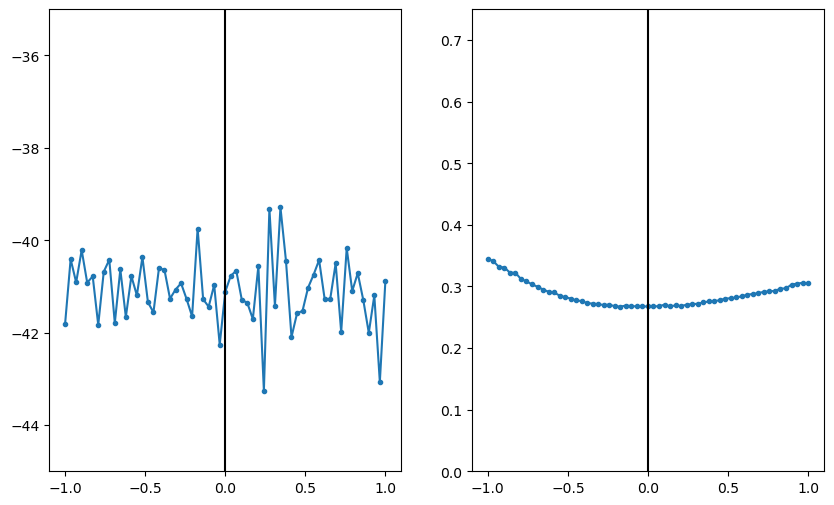

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(np.linspace(-0.009,0.009,length), list, marker = '.')
plt.ylim(-45,-35)
plt.axvline(x = 0, color = 'black')
plt.subplot(1,2,2)
plt.plot(np.linspace(-1,1,length), eslist, marker = '.')
plt.ylim(-0,0.75)
plt.axvline(x = 0, color = 'black')
plt.show()


In [ ]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20
simulations = 100
ensmembers = 50


list = []
eslist = []
mselist = []
variolist = [] 
length = 59
for change in np.linspace(-1,1,length):
    full1sims = np.zeros((simulations,predl,size*size*2))
    for i in range(simulations):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
        full1 = interveave(Vpred1,Hpred1,size,predl)
        full1sims[i,:,:] = full1
    #plotsequence(Vpred1,Hpred1,predl)

    full2ens = np.zeros((ensmembers,predl,size*size*2))
    for i in range(ensmembers):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b+change,c,d,s,t)
        full2 = interveave(Vpred1,Hpred1,size,predl)
        full2ens[i,:,:] = full2
    plotsequence(Vpred1,Hpred1,predl)
    es = energy_score(full2ens, full1sims)
    mse = MSE(full2ens,full1sims)
    variogram = variogram_score(full2ens,full1sims)
    #print(f"Expected Energy Score: {es:.4f}")

    full1sims  = sigkernel.transform(full1sims, at=True)
    full1sims = torch.tensor(full1sims, device='cuda')

    full2ens  = sigkernel.transform(full2ens, at=True)
    full2ens = torch.tensor(full2ens, device='cuda') #dtype

    #print(full1sims.shape)
    #print(full2ens.shape)

    static = sigkernel.Linear_ID_Kernel()
    sigker = sigkernel.SigKernel(static, 2)

    K = sigker.compute_scoring_rule(full2ens,full1sims)
    # if change == 0:
    #     print(change)
    # print(K.item())
    list.append(K.item())
    eslist.append(es)
    mselist.append(mse)
    variolist.append(variogram)

In [ ]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20
simulations = 100
ensmembers = 50


list = []
eslist = []
length = 59
for change in np.linspace(-0.009,0.009,length):
    full1sims = np.zeros((simulations,predl,size*size*2))
    for i in range(simulations):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
        full1 = interveave(Vpred1,Hpred1,size,predl)
        full1sims[i,:,:] = full1
    #plotsequence(Vpred1,Hpred1,predl)

    full2ens = np.zeros((ensmembers,predl,size*size*2))
    for i in range(ensmembers):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s+change,t)
        full2 = interveave(Vpred1,Hpred1,size,predl)
        full2ens[i,:,:] = full2
    plotsequence(Vpred1,Hpred1,predl)
    es = energy_score(full2ens, full1sims)
    #print(f"Expected Energy Score: {es:.4f}")

    full1sims  = sigkernel.transform(full1sims, at=True)
    full1sims = torch.tensor(full1sims, device='cuda')

    full2ens  = sigkernel.transform(full2ens, at=True)
    full2ens = torch.tensor(full2ens, device='cuda') #dtype

    #print(full1sims.shape)
    #print(full2ens.shape)

    static = sigkernel.Linear_ID_Kernel()
    sigker = sigkernel.SigKernel(static, 2)

    K = sigker.compute_scoring_rule(full2ens,full1sims)
    # if change == 0:
    #     print(change)
    # print(K.item())
    list.append(K.item())
    eslist.append(es)

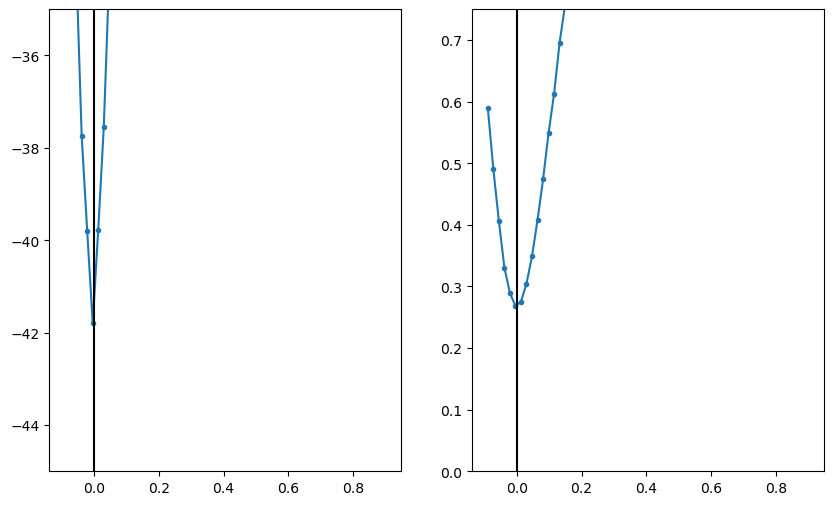

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(np.linspace(-0.09,0.9,length), list, marker = '.')
plt.ylim(-45,-35)
plt.axvline(x = 0, color = 'black')
plt.subplot(1,2,2)
plt.plot(np.linspace(-0.09,0.9,length), eslist, marker = '.')
plt.ylim(-0,0.75)
plt.axvline(x = 0, color = 'black')
plt.show()


In [205]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20
simulations = 100
ensmembers = 50


list = []
length = 59
for change in np.linspace(-0.25,0.25,length):
    full1sims = np.zeros((simulations,predl,size*size*2))
    for i in range(simulations):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
        full1 = interveave(Vpred1,Hpred1,size,predl)
        full1sims[i,:,:] = full1
    #plotsequence(Vpred1,Hpred1,predl)

    full2ens = np.zeros((ensmembers,predl,size*size*2))
    for i in range(ensmembers):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b+change,c,d,s,t)
        full2 = interveave(Vpred1,Hpred1,size,predl)
        full2ens[i,:,:] = full2
    #plotsequence(Vpred1,Hpred1,predl)


    full1sims  = sigkernel.transform(full1sims, at=True)
    full1sims = torch.tensor(full1sims, device='cuda')

    full2ens  = sigkernel.transform(full2ens, at=True)
    full2ens = torch.tensor(full2ens, device='cuda') #dtype

    #print(full1sims.shape)
    #print(full2ens.shape)

    static = sigkernel.Linear_ID_Kernel()
    sigker = sigkernel.SigKernel(static, 2)

    K = sigker.compute_scoring_rule(full2ens,full1sims)
    if change == 0:
        print(change)
    print(K.item())
    list.append(K.item())

-24.311648091168184
-25.015491017806205
-26.048359645225265
-27.066989189373654
-28.62202866388636
-30.348539648204593
-31.339054313965885
-32.68415088710554
-34.1238246355755
-36.50487084822176
-37.448834711466404
-39.61019413526074
-40.95285449866698
-42.75626111724891
-45.19719904109648
-46.37507327690142
-48.43460631698662
-50.151137097907615
-52.216169916355184
-54.76992759523911
-57.05165742160836
-58.732165432768284
-61.223136538152275
-61.668241908160766
-65.07728605655609
-65.02549075979637
-67.12012863256312
-65.99760312857212
-70.0321479256024
0.0
-69.84598769104387
-68.17879438395063
-63.809787558807315
-65.58017356696861
-62.84266487812009
-60.932084874318036
-59.06450126668972
-47.86482410255044
-35.295968054296765
-19.159205613435034
-3.9455752951726595
5.022408691738946
22.628908015758327
65.34996937235837
90.2621950765672
139.3344082421783
198.81996072124872
248.31533384902593
305.07656513539246
395.5312060009886
539.4105933721571
678.805093846312
829.3790035281319
108

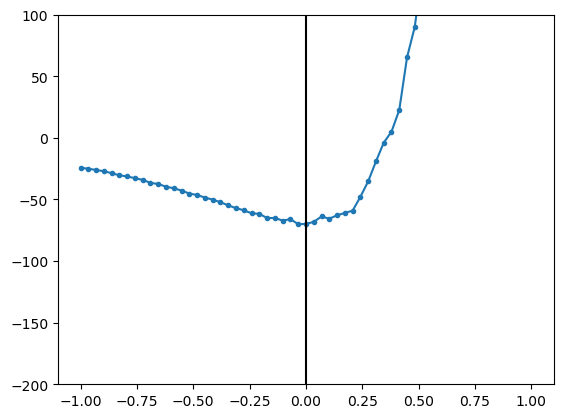

In [206]:
plt.plot(np.linspace(-1,1,length), list, marker = '.')
plt.ylim(-200,100)
plt.axvline(x = 0, color = 'black')
plt.show()

In [213]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20
simulations = 100
ensmembers = 50


list = []
length = 59
for change in np.linspace(0.25,1.75,length):
    full1sims = np.zeros((simulations,predl,size*size*2))
    for i in range(simulations):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
        full1 = interveave(Vpred1,Hpred1,size,predl)
        full1sims[i,:,:] = full1

    full2ens = np.zeros((ensmembers,predl,size*size*2))
    for i in range(ensmembers):
        Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t*change)
        full2 = interveave(Vpred1,Hpred1,size,predl)
        full2ens[i,:,:] = full2

    full1sims  = sigkernel.transform(full1sims, at=True)
    full1sims = torch.tensor(full1sims, device='cuda')

    full2ens  = sigkernel.transform(full2ens, at=True)
    full2ens = torch.tensor(full2ens, device='cuda') #dtype

    static = sigkernel.Linear_ID_Kernel()
    sigker = sigkernel.SigKernel(static, 2)

    K = sigker.compute_scoring_rule(full2ens,full1sims)
    if change == 1:
        print(change)
    print(K.item())
    list.append(K.item())

-6.335085670506153
-7.098644220678945
-7.585764590379098
-8.456412951143424
-9.237795207492631
-9.923928071670995
-11.443190416849747
-11.966998850645467
-13.329368747891909
-14.897406915273157
-16.068139375664682
-17.844490278589692
-19.796801125746697
-21.544997311820033
-23.71790098512775
-25.994880453381132
-27.468350003185037
-31.00906666549455
-33.80050585181978
-36.32593648912875
-39.93650120437837
-43.56791479232042
-46.940795756041844
-51.107979649939864
-55.84462774899124
-59.771939114840634
-63.743867215932944
-65.39473127971246
-68.57614166372477
-69.33967161072745
-67.61181436540214
-63.39117590263034
-51.451006164169286
-37.38682641371821
-21.84337662836444
3.3724608534366496
52.98095782821724
116.48720380077492
207.16612077009648
291.8620324265199
501.4378137261132
699.2892979451784
1027.7491396473201
1301.5340348723396
1934.432174660715
2413.5149397903174
3441.6055663435463
4431.0278215806475
5775.01404410873
7612.085669059872
10249.17136485511
13376.107145461949
17591.

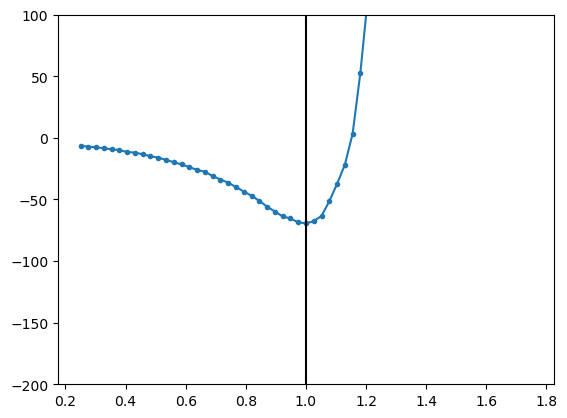

In [214]:
plt.plot(np.linspace(0.25,1.75,length), list, marker = '.')
plt.ylim(-200,100)
plt.axvline(x = 1, color = 'black')
plt.show()

In [70]:
a = 0.1 #a #0.1   Vegetation growth
b = 1.2# b# 1.2 #Fire start senseitivity
c = 0.3# c#0.3 #Combustion rate
d = 0.4#d#0.4 #Fire decay
s = 0.01#s#0.01 #Noise scale
t = 0.2#t#0.2
size = 10
predl =20

for val in range(20):
    Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
    #plotsequence(Vpred1,Hpred1,predl)
    full1 = interveave(Vpred1,Hpred1,size,predl)/(val+1)
    Vpred1,Hpred1 = predictout(VBase,HBase,size,predl,a,b,c,d,s,t)
    #plotsequence(Vpred1,Hpred1,predl)
    full2 = interveave(Vpred1,Hpred1,size,predl)/(val+1)


    full1 = np.expand_dims(full1,axis=0)
    full1  = sigkernel.transform(full1, at=True)
    full1 = torch.tensor(full1, device='cuda')
    full2 = np.expand_dims(full2,axis=0)
    full2  = sigkernel.transform(full2, at=True)
    full2 = torch.tensor(full2, device='cuda') #dtype

    static = sigkernel.Linear_ID_Kernel()
    sigker = sigkernel.SigKernel(static, 2)

    K = sigker.compute_kernel(full1,full2)
    print(K)


tensor([68.1250], device='cuda:0', dtype=torch.float64)
